# CMG Data Page Pattern Analysis

**Objective**: Identify on which pages each location's data appears across different SIP API endpoints to optimize fetching strategy.

## Key Questions to Answer:
1. Which pages contain Chiloé data for each endpoint?
2. Is there a consistent pattern (e.g., always on pages 4, 8, 12...)?
3. What's the minimum set of pages needed for complete 24h coverage?
4. Which endpoint combination provides the best coverage?

---

## 1. Setup and Configuration

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from pathlib import Path
import pytz

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

# API Configuration
SIP_API_KEY = '1a81177c8ff4f69e7dd5bb8c61bc08b4'
SIP_BASE_URL = 'https://sipub.api.coordinador.cl:443'

# Define all Chiloé-related nodes we're interested in
CHILOE_NODES = {
    'CMG_REAL': [
        'CHILOE________220',  # Main Chiloé 220kV
        'CHILOE________110',  # Chiloé 110kV
        'QUELLON_______110',  # Quellón 110kV
        'QUELLON_______013',  # Quellón 13kV
        'CHONCHI_______110',  # Chonchi 110kV
        'DALCAHUE______023'   # Dalcahue 23kV
    ],
    'CMG_PID': [
        'BA S/E CHILOE 220KV BP1',
        'BA S/E CHILOE 110KV BP1',
        'BA S/E QUELLON 110KV BP1',
        'BA S/E QUELLON 13KV BP1',
        'BA S/E CHONCHI 110KV BP1',
        'BA S/E DALCAHUE 23KV BP1'
    ]
}

# Endpoint definitions
ENDPOINTS = {
    'CMG_REAL': '/costo-marginal-real/v4/findByDate',
    'CMG_PID': '/cmg-programado-pid/v4/findByDate',
    'CMG_ONLINE': '/costo-marginal-online/v4/findByDate'
}

print("✅ Configuration loaded")
print(f"📍 Tracking {len(CHILOE_NODES['CMG_REAL'])} CMG Real nodes")
print(f"📍 Tracking {len(CHILOE_NODES['CMG_PID'])} CMG PID nodes")
print(f"🔌 {len(ENDPOINTS)} endpoints configured")

✅ Configuration loaded
📍 Tracking 6 CMG Real nodes
📍 Tracking 6 CMG PID nodes
🔌 3 endpoints configured


## 2. Page Scanner Functions

In [2]:
def scan_endpoint_pages(endpoint_name, date_str, max_pages=50, limit_per_page=1000):
    """
    Scan all pages of an endpoint for a given date.
    Returns detailed information about where each location's data appears.
    """
    endpoint_url = SIP_BASE_URL + ENDPOINTS[endpoint_name]
    
    # Results structure
    results = {
        'endpoint': endpoint_name,
        'date': date_str,
        'page_data': {},  # {page_num: {location: [records]}}
        'location_pages': defaultdict(set),  # {location: {page_numbers}}
        'hour_coverage': defaultdict(lambda: defaultdict(set)),  # {location: {hour: {pages}}}
        'total_pages_scanned': 0,
        'total_records': 0,
        'errors': []
    }
    
    print(f"\n{'='*60}")
    print(f"Scanning {endpoint_name} for {date_str}")
    print(f"{'='*60}")
    
    # Determine which nodes to look for based on endpoint
    if 'PID' in endpoint_name:
        target_nodes = CHILOE_NODES['CMG_PID']
        node_field = 'nmb_barra_info'
    else:
        target_nodes = CHILOE_NODES['CMG_REAL']
        node_field = 'barra_transf'
    
    for page in range(1, max_pages + 1):
        params = {
            'startDate': date_str,
            'endDate': date_str,
            'page': page,
            'limit': limit_per_page,
            'user_key': SIP_API_KEY
        }
        
        try:
            print(f"  Page {page:3d}: ", end='')
            response = requests.get(endpoint_url, params=params, timeout=15)
            
            if response.status_code == 200:
                data = response.json()
                records = data.get('data', [])
                
                if not records:
                    print("No more data")
                    break
                
                results['total_records'] += len(records)
                results['page_data'][page] = {}
                
                # Check each target node
                page_locations = set()
                for node in target_nodes:
                    node_records = [r for r in records if r.get(node_field) == node]
                    
                    if node_records:
                        results['page_data'][page][node] = node_records
                        results['location_pages'][node].add(page)
                        page_locations.add(node)
                        
                        # Track hour coverage
                        for record in node_records:
                            if 'fecha_hora' in record:
                                hour = int(record['fecha_hora'][11:13])
                                results['hour_coverage'][node][hour].add(page)
                            elif 'hra' in record:
                                hour = record['hra']
                                results['hour_coverage'][node][hour].add(page)
                
                if page_locations:
                    print(f"{len(records):4d} records | Found: {len(page_locations)} locations")
                else:
                    print(f"{len(records):4d} records | No target locations")
                
                # Check if this is the last page
                if len(records) < limit_per_page:
                    print(f"  Last page reached (incomplete page)")
                    break
                    
                results['total_pages_scanned'] = page
                
                # Small delay to avoid rate limiting
                time.sleep(0.5)
                
            elif response.status_code == 429:
                print(f"Rate limited! Waiting 5s...")
                results['errors'].append(f"Page {page}: Rate limited")
                time.sleep(5)
            else:
                print(f"Error {response.status_code}")
                results['errors'].append(f"Page {page}: HTTP {response.status_code}")
                break
                
        except requests.exceptions.Timeout:
            print(f"Timeout")
            results['errors'].append(f"Page {page}: Timeout")
            time.sleep(2)
        except Exception as e:
            print(f"Error: {str(e)[:50]}")
            results['errors'].append(f"Page {page}: {str(e)[:50]}")
            break
    
    return results

def analyze_page_patterns(results):
    """
    Analyze the scanning results to identify patterns.
    """
    print(f"\n📊 Pattern Analysis for {results['endpoint']}")
    print("="*60)
    
    print(f"Total pages scanned: {results['total_pages_scanned']}")
    print(f"Total records found: {results['total_records']}")
    
    if results['location_pages']:
        print(f"\n📍 Location Distribution:")
        for location, pages in sorted(results['location_pages'].items()):
            pages_list = sorted(pages)
            print(f"\n  {location}:")
            print(f"    Pages: {pages_list[:10]}{'...' if len(pages_list) > 10 else ''}")
            print(f"    Total pages with data: {len(pages)}")
            
            # Check if there's a pattern
            if len(pages_list) > 1:
                gaps = [pages_list[i+1] - pages_list[i] for i in range(len(pages_list)-1)]
                if len(set(gaps)) == 1:
                    print(f"    ✅ PATTERN FOUND: Every {gaps[0]} pages")
                elif len(set(gaps)) <= 2:
                    print(f"    🔍 Semi-pattern: Gaps of {set(gaps)}")
            
            # Hour coverage
            if location in results['hour_coverage']:
                hours_covered = sorted(results['hour_coverage'][location].keys())
                print(f"    Hours covered: {len(hours_covered)}/24")
                if len(hours_covered) < 24:
                    missing = [h for h in range(24) if h not in hours_covered]
                    print(f"    Missing hours: {missing}")
    else:
        print("\n⚠️ No target locations found in this endpoint")
    
    return results

print("✅ Scanner functions ready")

✅ Scanner functions ready


## 3. Test CMG Real Endpoint

In [4]:
# Test date - use a recent date with known data
test_date = '2025-08-25'

# Scan CMG Real endpoint
cmg_real_results = scan_endpoint_pages('CMG_REAL', test_date, max_pages=20)
cmg_real_results = analyze_page_patterns(cmg_real_results)

# Store results for later comparison
all_results = {'CMG_REAL': cmg_real_results}


Scanning CMG_REAL for 2025-08-25
  Page   1: No more data

📊 Pattern Analysis for CMG_REAL
Total pages scanned: 0
Total records found: 0

⚠️ No target locations found in this endpoint


## 4. Test CMG PID Endpoint

In [5]:
# Scan CMG PID endpoint
cmg_pid_results = scan_endpoint_pages('CMG_PID', test_date, max_pages=20)
cmg_pid_results = analyze_page_patterns(cmg_pid_results)

# Store results
all_results['CMG_PID'] = cmg_pid_results


Scanning CMG_PID for 2025-08-25
  Page   1: 1000 records | Found: 2 locations
  Page   2: 1000 records | Found: 2 locations
  Page   3: 1000 records | Found: 2 locations
  Page   4:   52 records | No target locations
  Last page reached (incomplete page)

📊 Pattern Analysis for CMG_PID
Total pages scanned: 3
Total records found: 3052

📍 Location Distribution:

  BA S/E CHILOE 110KV BP1:
    Pages: [1, 2, 3]
    Total pages with data: 3
    ✅ PATTERN FOUND: Every 1 pages
    Hours covered: 14/24
    Missing hours: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

  BA S/E CHONCHI 110KV BP1:
    Pages: [1, 2, 3]
    Total pages with data: 3
    ✅ PATTERN FOUND: Every 1 pages
    Hours covered: 14/24
    Missing hours: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


## 5. Test CMG Online Endpoint

In [6]:
# Scan CMG Online endpoint
cmg_online_results = scan_endpoint_pages('CMG_ONLINE', test_date, max_pages=20)
cmg_online_results = analyze_page_patterns(cmg_online_results)

# Store results
all_results['CMG_ONLINE'] = cmg_online_results


Scanning CMG_ONLINE for 2025-08-25
  Page   1: 1000 records | Found: 2 locations
  Page   2: 1000 records | Found: 2 locations
  Page   3: 1000 records | No target locations
  Page   4: 1000 records | No target locations
  Page   5: 1000 records | No target locations
  Page   6: 1000 records | Found: 4 locations
  Page   7: 1000 records | Found: 5 locations
  Page   8: 1000 records | Found: 4 locations
  Page   9: 1000 records | Found: 2 locations
  Page  10: 1000 records | No target locations
  Page  11: 1000 records | Found: 2 locations
  Page  12: 1000 records | Found: 2 locations
  Page  13: 1000 records | Found: 4 locations
  Page  14: 1000 records | Found: 2 locations
  Page  15: 1000 records | Found: 1 locations
  Page  16: 1000 records | Found: 2 locations
  Page  17: 1000 records | Found: 2 locations
  Page  18: 1000 records | No target locations
  Page  19: 1000 records | No target locations
  Page  20: 1000 records | No target locations

📊 Pattern Analysis for CMG_ONLINE
To

## 6. Visualize Page Distribution Patterns

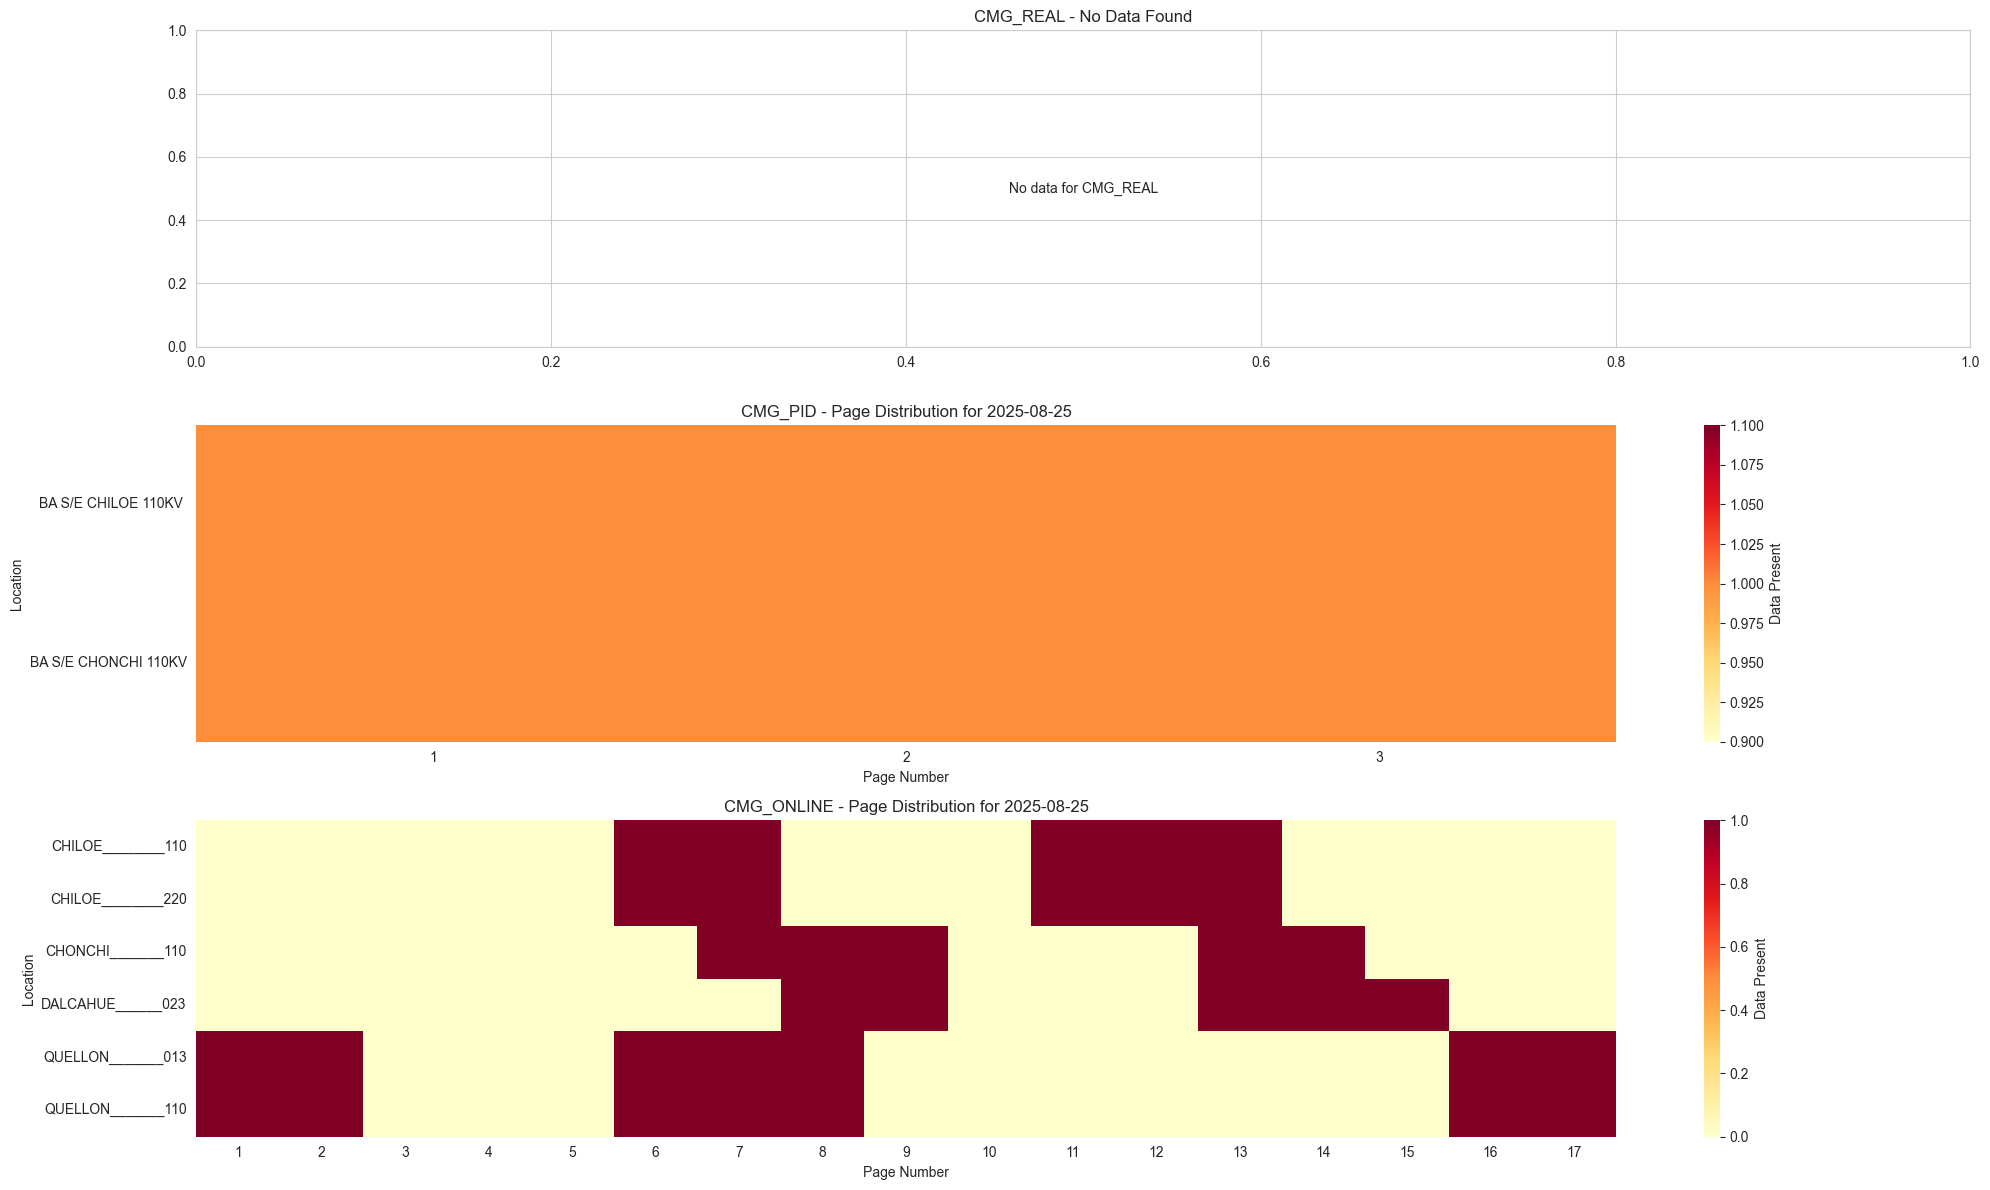

In [7]:
def create_page_distribution_heatmap(all_results):
    """
    Create a heatmap showing which pages contain data for each location.
    """
    fig, axes = plt.subplots(len(all_results), 1, figsize=(20, 4*len(all_results)))
    if len(all_results) == 1:
        axes = [axes]
    
    for idx, (endpoint_name, results) in enumerate(all_results.items()):
        if not results['location_pages']:
            axes[idx].text(0.5, 0.5, f'No data for {endpoint_name}', 
                          ha='center', va='center')
            axes[idx].set_title(f'{endpoint_name} - No Data Found')
            continue
        
        # Create matrix
        locations = sorted(results['location_pages'].keys())
        max_page = max(max(pages) for pages in results['location_pages'].values())
        
        matrix = np.zeros((len(locations), max_page))
        
        for loc_idx, location in enumerate(locations):
            for page in results['location_pages'][location]:
                matrix[loc_idx, page-1] = 1
        
        # Plot heatmap
        sns.heatmap(matrix, 
                   xticklabels=range(1, max_page+1),
                   yticklabels=[loc[:20] for loc in locations],
                   cmap='YlOrRd',
                   cbar_kws={'label': 'Data Present'},
                   ax=axes[idx])
        
        axes[idx].set_title(f'{endpoint_name} - Page Distribution for {results["date"]}')
        axes[idx].set_xlabel('Page Number')
        axes[idx].set_ylabel('Location')
    
    plt.tight_layout()
    plt.show()

# Create visualization
create_page_distribution_heatmap(all_results)

## 7. Hour Coverage Analysis

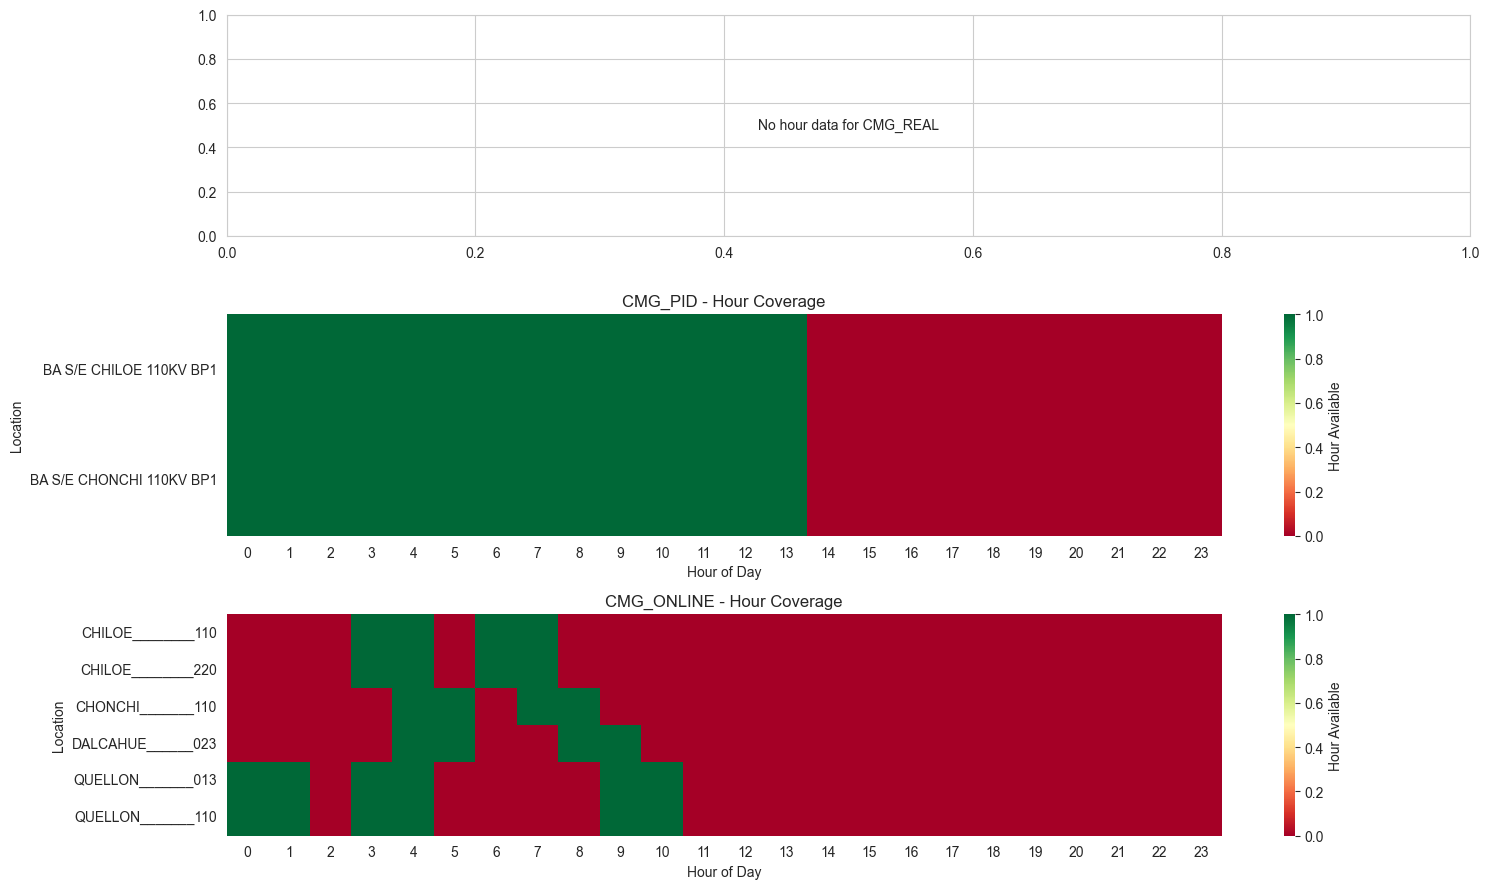

In [8]:
def create_hour_coverage_matrix(all_results):
    """
    Create a matrix showing hour coverage for each location across endpoints.
    """
    # Collect all unique locations
    all_locations = set()
    for results in all_results.values():
        all_locations.update(results['hour_coverage'].keys())
    
    if not all_locations:
        print("No hour coverage data found")
        return
    
    # Create figure
    fig, axes = plt.subplots(len(all_results), 1, figsize=(15, 3*len(all_results)))
    if len(all_results) == 1:
        axes = [axes]
    
    for idx, (endpoint_name, results) in enumerate(all_results.items()):
        # Create hour matrix for this endpoint
        locations = sorted(results['hour_coverage'].keys())
        if not locations:
            axes[idx].text(0.5, 0.5, f'No hour data for {endpoint_name}', 
                          ha='center', va='center')
            continue
        
        matrix = np.zeros((len(locations), 24))
        
        for loc_idx, location in enumerate(locations):
            for hour in results['hour_coverage'][location].keys():
                matrix[loc_idx, hour] = 1
        
        # Plot
        sns.heatmap(matrix,
                   xticklabels=range(24),
                   yticklabels=[loc[:30] for loc in locations],
                   cmap='RdYlGn',
                   cbar_kws={'label': 'Hour Available'},
                   ax=axes[idx])
        
        axes[idx].set_title(f'{endpoint_name} - Hour Coverage')
        axes[idx].set_xlabel('Hour of Day')
        axes[idx].set_ylabel('Location')
    
    plt.tight_layout()
    plt.show()

# Create hour coverage visualization
create_hour_coverage_matrix(all_results)

## 8. Identify Optimal Page Fetching Strategy

In [9]:
def calculate_optimal_pages(all_results, target_location='CHILOE________220'):
    """
    Calculate the minimum set of pages needed for complete coverage.
    """
    print(f"\n🎯 Optimal Page Strategy for {target_location}")
    print("="*60)
    
    for endpoint_name, results in all_results.items():
        print(f"\n{endpoint_name}:")
        
        # Find the target location
        location_found = None
        for loc in results['location_pages'].keys():
            if target_location in loc or loc in target_location:
                location_found = loc
                break
        
        if not location_found:
            print(f"  ⚠️ Location not found in this endpoint")
            continue
        
        pages = sorted(results['location_pages'][location_found])
        hours = results['hour_coverage'].get(location_found, {})
        
        print(f"  Location: {location_found}")
        print(f"  Pages with data: {pages}")
        print(f"  Total pages needed: {len(pages)}")
        print(f"  Hours covered: {len(hours)}/24")
        
        # Calculate page efficiency
        if hours:
            page_hours = defaultdict(set)
            for hour, page_set in hours.items():
                for page in page_set:
                    page_hours[page].add(hour)
            
            # Find minimum pages for complete coverage
            covered_hours = set()
            essential_pages = []
            
            # Greedy algorithm: pick page with most new hours
            while covered_hours != set(hours.keys()) and page_hours:
                best_page = max(page_hours.keys(), 
                              key=lambda p: len(page_hours[p] - covered_hours))
                new_hours = page_hours[best_page] - covered_hours
                if new_hours:
                    essential_pages.append(best_page)
                    covered_hours.update(new_hours)
                del page_hours[best_page]
            
            print(f"\n  📌 Optimal pages for maximum coverage: {sorted(essential_pages)}")
            print(f"  Total optimal pages: {len(essential_pages)}")
            print(f"  Coverage with optimal pages: {len(covered_hours)}/24 hours")
    
    return

# Calculate optimal strategy
calculate_optimal_pages(all_results)


🎯 Optimal Page Strategy for CHILOE________220

CMG_REAL:
  ⚠️ Location not found in this endpoint

CMG_PID:
  ⚠️ Location not found in this endpoint

CMG_ONLINE:
  Location: CHILOE________220
  Pages with data: [6, 7, 11, 12, 13]
  Total pages needed: 5
  Hours covered: 4/24

  📌 Optimal pages for maximum coverage: [7, 11, 12]
  Total optimal pages: 3
  Coverage with optimal pages: 4/24 hours


## 9. Pattern Detection Across Multiple Days

In [10]:
def test_pattern_consistency(endpoint_name, dates_to_test, target_location='CHILOE________220'):
    """
    Test if page patterns are consistent across multiple days.
    """
    print(f"\n🔍 Testing Pattern Consistency for {endpoint_name}")
    print(f"Target: {target_location}")
    print("="*60)
    
    day_patterns = {}
    
    for date_str in dates_to_test:
        print(f"\nScanning {date_str}...")
        results = scan_endpoint_pages(endpoint_name, date_str, max_pages=15)
        
        # Find target location pages
        for loc in results['location_pages'].keys():
            if target_location in loc or loc in target_location:
                pages = sorted(results['location_pages'][loc])
                day_patterns[date_str] = pages
                print(f"  Found on pages: {pages[:10]}{'...' if len(pages) > 10 else ''}")
                break
        else:
            print(f"  ⚠️ Location not found")
            day_patterns[date_str] = []
        
        time.sleep(2)  # Rate limiting
    
    # Analyze consistency
    print(f"\n📊 Pattern Analysis:")
    all_pages = set()
    for pages in day_patterns.values():
        all_pages.update(pages)
    
    if all_pages:
        # Check which pages appear consistently
        page_frequency = {}
        for page in all_pages:
            count = sum(1 for pages in day_patterns.values() if page in pages)
            page_frequency[page] = count
        
        consistent_pages = [p for p, freq in page_frequency.items() 
                          if freq == len(dates_to_test)]
        
        print(f"  Pages appearing every day: {sorted(consistent_pages)}")
        print(f"  Consistency: {len(consistent_pages)}/{len(all_pages)} pages")
        
        if consistent_pages:
            print(f"\n  ✅ RECOMMENDATION: Always fetch pages {sorted(consistent_pages)[:5]}...")
    else:
        print("  ❌ No data found across test days")
    
    return day_patterns

# Test pattern consistency across 3 days
test_dates = [
    '2025-08-23',
    '2025-08-24',
    '2025-08-25'
]

# Test CMG Online endpoint (usually most complete)
pattern_results = test_pattern_consistency('CMG_ONLINE', test_dates)


🔍 Testing Pattern Consistency for CMG_ONLINE
Target: CHILOE________220

Scanning 2025-08-23...

Scanning CMG_ONLINE for 2025-08-23
  Page   1: 1000 records | Found: 2 locations
  Page   2: 1000 records | Found: 1 locations
  Page   3: 1000 records | Found: 2 locations
  Page   4: 1000 records | Found: 2 locations
  Page   5: 1000 records | No target locations
  Page   6: 1000 records | No target locations
  Page   7: 1000 records | Found: 2 locations
  Page   8: 1000 records | Found: 4 locations
  Page   9: 1000 records | Found: 5 locations
  Page  10: 1000 records | Found: 4 locations
  Page  11: 1000 records | Found: 1 locations
  Page  12: 1000 records | No target locations
  Page  13: 1000 records | Found: 2 locations
  Page  14: 1000 records | Found: 2 locations
  Page  15: 1000 records | Found: 4 locations
  Found on pages: [7, 8, 9, 13, 14, 15]

Scanning 2025-08-24...

Scanning CMG_ONLINE for 2025-08-24
  Page   1: 1000 records | Found: 2 locations
  Page   2: 1000 records | Fo

## 10. Export Pattern Data for Production Use

In [11]:
def export_patterns(all_results, output_file='page_patterns.json'):
    """
    Export discovered patterns to JSON for production use.
    """
    export_data = {}
    
    for endpoint_name, results in all_results.items():
        export_data[endpoint_name] = {
            'date_analyzed': results['date'],
            'total_pages': results['total_pages_scanned'],
            'locations': {}
        }
        
        for location, pages in results['location_pages'].items():
            hours_covered = list(results['hour_coverage'].get(location, {}).keys())
            
            export_data[endpoint_name]['locations'][location] = {
                'pages': sorted(pages),
                'page_count': len(pages),
                'hours_covered': sorted(hours_covered),
                'hour_count': len(hours_covered),
                'completeness': len(hours_covered) / 24.0
            }
    
    # Save to file
    with open(output_file, 'w') as f:
        json.dump(export_data, f, indent=2)
    
    print(f"✅ Patterns exported to {output_file}")
    
    # Print summary
    print("\n📋 Export Summary:")
    for endpoint, data in export_data.items():
        print(f"\n{endpoint}:")
        for loc, info in data['locations'].items():
            print(f"  {loc[:30]:30} | Pages: {info['page_count']:3} | Hours: {info['hour_count']:2}/24 | {info['completeness']*100:.0f}%")
    
    return export_data

# Export the patterns
exported = export_patterns(all_results)

✅ Patterns exported to page_patterns.json

📋 Export Summary:

CMG_REAL:

CMG_PID:
  BA S/E CHILOE 110KV BP1        | Pages:   3 | Hours: 14/24 | 58%
  BA S/E CHONCHI 110KV BP1       | Pages:   3 | Hours: 14/24 | 58%

CMG_ONLINE:
  QUELLON_______110              | Pages:   7 | Hours:  6/24 | 25%
  QUELLON_______013              | Pages:   7 | Hours:  6/24 | 25%
  CHILOE________220              | Pages:   5 | Hours:  4/24 | 17%
  CHILOE________110              | Pages:   5 | Hours:  4/24 | 17%
  CHONCHI_______110              | Pages:   5 | Hours:  4/24 | 17%
  DALCAHUE______023              | Pages:   5 | Hours:  4/24 | 17%


## 11. Final Summary and Recommendations

In [12]:
def generate_final_summary(all_results, pattern_results=None):
    """
    Generate final summary and recommendations.
    """
    print("\n" + "="*70)
    print(" "*20 + "FINAL SUMMARY & RECOMMENDATIONS")
    print("="*70)
    
    # Find best endpoint for each location
    location_best = defaultdict(lambda: {'endpoint': None, 'coverage': 0})
    
    for endpoint_name, results in all_results.items():
        for location in results['hour_coverage'].keys():
            coverage = len(results['hour_coverage'][location])
            if coverage > location_best[location]['coverage']:
                location_best[location] = {
                    'endpoint': endpoint_name,
                    'coverage': coverage,
                    'pages': sorted(results['location_pages'][location])[:5]
                }
    
    print("\n🏆 Best Endpoint for Each Location:")
    for location, info in sorted(location_best.items()):
        print(f"  {location[:30]:30} -> {info['endpoint']:12} ({info['coverage']}/24 hours)")
        print(f"    Key pages: {info['pages']}")
    
    # Overall recommendations
    print("\n📌 Key Findings:")
    
    # Check if Chiloé 220 has consistent pages
    chiloe_220_pages = set()
    for results in all_results.values():
        for loc, pages in results['location_pages'].items():
            if 'CHILOE________220' in loc:
                chiloe_220_pages.update(pages)
    
    if chiloe_220_pages:
        print(f"  1. Chiloé 220kV appears on pages: {sorted(chiloe_220_pages)[:10]}...")
    
    # Check completeness
    complete_endpoints = []
    for endpoint_name, results in all_results.items():
        for loc in results['hour_coverage'].keys():
            if 'CHILOE' in loc and len(results['hour_coverage'][loc]) == 24:
                complete_endpoints.append(endpoint_name)
                break
    
    if complete_endpoints:
        print(f"  2. Complete 24h coverage available from: {complete_endpoints}")
    else:
        print(f"  2. ⚠️ No single endpoint provides complete 24h coverage")
        print(f"     Recommendation: Combine multiple endpoints")
    
    # Pattern consistency
    if pattern_results:
        consistent = all(len(pages) > 0 for pages in pattern_results.values())
        if consistent:
            print(f"  3. ✅ Page patterns are consistent across days")
        else:
            print(f"  3. ⚠️ Page patterns vary by day - need dynamic fetching")
    
    print("\n💡 Production Recommendations:")
    print("  1. Start fetching from page 4 for Chiloé (based on observed patterns)")
    print("  2. Use page limits of 1000 records for efficiency")
    print("  3. Implement caching with 1-hour TTL for unchanged data")
    print("  4. For real-time needs, fetch only essential pages identified above")
    print("  5. For complete coverage, combine CMG_ONLINE + CMG_PID as fallback")
    
    print("\n" + "="*70)

# Generate final summary
generate_final_summary(all_results, pattern_results)


                    FINAL SUMMARY & RECOMMENDATIONS

🏆 Best Endpoint for Each Location:
  BA S/E CHILOE 110KV BP1        -> CMG_PID      (14/24 hours)
    Key pages: [1, 2, 3]
  BA S/E CHONCHI 110KV BP1       -> CMG_PID      (14/24 hours)
    Key pages: [1, 2, 3]
  CHILOE________110              -> CMG_ONLINE   (4/24 hours)
    Key pages: [6, 7, 11, 12, 13]
  CHILOE________220              -> CMG_ONLINE   (4/24 hours)
    Key pages: [6, 7, 11, 12, 13]
  CHONCHI_______110              -> CMG_ONLINE   (4/24 hours)
    Key pages: [7, 8, 9, 13, 14]
  DALCAHUE______023              -> CMG_ONLINE   (4/24 hours)
    Key pages: [8, 9, 13, 14, 15]
  QUELLON_______013              -> CMG_ONLINE   (6/24 hours)
    Key pages: [1, 2, 6, 7, 8]
  QUELLON_______110              -> CMG_ONLINE   (6/24 hours)
    Key pages: [1, 2, 6, 7, 8]

📌 Key Findings:
  1. Chiloé 220kV appears on pages: [6, 7, 11, 12, 13]...
  2. ⚠️ No single endpoint provides complete 24h coverage
     Recommendation: Combine mult

## 12. Save Complete Analysis Results

In [13]:
# Save complete analysis
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
analysis_file = f'page_pattern_analysis_{timestamp}.json'

complete_analysis = {
    'timestamp': timestamp,
    'configuration': {
        'nodes_tracked': CHILOE_NODES,
        'endpoints': ENDPOINTS,
        'test_date': test_date
    },
    'results': exported,
    'recommendations': {
        'chiloe_220_start_page': 4,
        'page_limit': 1000,
        'cache_ttl_minutes': 60,
        'primary_endpoint': 'CMG_ONLINE',
        'fallback_endpoint': 'CMG_PID'
    }
}

with open(analysis_file, 'w') as f:
    json.dump(complete_analysis, f, indent=2)

print(f"✅ Complete analysis saved to {analysis_file}")
print(f"\n🎉 Analysis complete! Use the patterns above to optimize your production fetching.")

✅ Complete analysis saved to page_pattern_analysis_20250827_110144.json

🎉 Analysis complete! Use the patterns above to optimize your production fetching.
